<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Experiments/1d_ntk_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q neural_tangents==0.2.2 livelossplot

In [ ]:
import jax
from jax import random, grad, jit, vmap
from jax.config import config
from jax.lib import xla_bridge
import jax.numpy as np
import neural_tangents as nt
from neural_tangents import stax
from jax.experimental import optimizers

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import matplotlib
import matplotlib.pylab as pylab
from matplotlib.lines import Line2D

import time

import numpy as onp

In [ ]:
# Utils

fplot = lambda x : np.fft.fftshift(np.log10(np.abs(np.fft.fft(x))))

# Signal makers

def sample_random_signal(key, decay_vec):
  N = decay_vec.shape[0]
  raw = random.normal(key, [N, 2]) @ np.array([1, 1j])
  signal_f = raw * decay_vec
  signal = np.real(np.fft.ifft(signal_f))
  return signal

def sample_random_powerlaw(key, N, power):
  coords = np.float32(np.fft.ifftshift(1 + N//2 - np.abs(np.fft.fftshift(np.arange(N)) - N//2)))
  decay_vec = coords ** -power
  return sample_random_signal(key, decay_vec) # * 100


# Network 

def make_network(num_layers, num_channels, num_outputs=1):
  layers = []
  for i in range(num_layers-1):
      layers.append(stax.Dense(num_channels, parameterization='standard'))
    #   layers.append(stax.Dense(num_channels, parameterization='ntk'))
      layers.append(stax.Relu(do_backprop=True))
  layers.append(stax.Dense(num_outputs, parameterization='standard'))
#   layers.append(stax.Dense(num_outputs, parameterization='ntk'))
  return stax.serial(*layers)

# Encoding 

def compute_ntk(x, avals, bvals, kernel_fn):
    x1_enc = input_encoder(x, avals, bvals)
    x2_enc = input_encoder(np.array([0.], dtype=np.float32), avals, bvals)
    out = np.squeeze(kernel_fn(x1_enc, x2_enc, 'ntk'))
    return out


input_encoder = lambda x, a, b: np.concatenate([a * np.sin((2.*np.pi*x[...,None]) * b), 
                                                a * np.cos((2.*np.pi*x[...,None]) * b)], axis=-1) / np.linalg.norm(a) #* np.sqrt(a.shape[0])



### complicated things

def predict(kernel_fn, yf_test, pred0f_test, ab, t_final, eta=None):
  N, M = yf_test.shape[-1]//2, 2
  alias_tile = lambda f : f.reshape(list(f.shape[:-1])+[M,N]).mean((-2)).tile([1]*len(f.shape[:-1])+[M])
  x_test = np.linspace(0., 1., N*M, endpoint=False)
  H_row_test = compute_ntk(x_test,  *ab, kernel_fn)
  H_t = np.real(np.fft.fft(H_row_test))
  H_d_tile = alias_tile(H_t)
  if eta is None:
    H_d_tile_train = 1. - np.exp(-t_final * H_d_tile)
  else:
    H_d_tile_train = 1. - (1. - eta * H_d_tile) ** t_final
  yf_train_tile = alias_tile(yf_test)
  pred0f_train_tile = alias_tile(pred0f_test)
  exp_term = H_d_tile_train * (yf_train_tile - pred0f_train_tile)
  pred_train = (pred0f_train_tile + exp_term)[...,:N]
  pred_test = pred0f_test + H_t / H_d_tile * exp_term

  pred_test = np.real(np.fft.ifft(pred_test))[1::2]
  pred_train = np.real(np.fft.ifft(pred_train))

  return pred_test, pred_train

predict = jit(predict, static_argnums=(0,))

def predict_psnr(kernel_fn, y_test, pred0f_test, ab, t_final, eta=None):
  yf_test = np.fft.fft(y_test)
  N, M = yf_test.shape[-1]//2, 2
  alias_tile = lambda f : f.reshape(list(f.shape[:-1])+[M,N]).mean((-2)).tile([1]*len(f.shape[:-1])+[M])
  pred_test, pred_train = predict(kernel_fn, yf_test, pred0f_test, ab, t_final, eta)
  calc_psnr = lambda f, g : -10*np.mean(np.log10(np.mean(np.abs(f - g)**2, -1)))
  return calc_psnr(y_test[1::2], pred_test), calc_psnr(y_test[::2], pred_train)

predict_psnr = jit(predict_psnr, static_argnums=(0,))

def optimize(rand_key, network_size, y_test, y_gt, t_final, ab_init, name, kernel_lr=.01, iters=800):
  kernel_fn = make_network(*network_size)[-1]

  def spectrum_loss(params):
    pred_test = predict(kernel_fn, np.fft.fft(y_test), np.zeros_like(y_test), (params[0], ab_init[1]), t_final)[0]
    return .5 * np.mean(np.abs(y_test[1::2] - pred_test)**2) / np.prod(y_test.shape[-1:])

  loss_grad = jit(jax.value_and_grad(spectrum_loss))

  kernel_opt_init, kernel_opt_update, kernel_get_params = optimizers.adam(kernel_lr)
  a_noise = np.abs(random.normal(rand_key, ab_init[0].shape)) * .001
  kernel_opt_state = kernel_opt_init((ab_init[0] + a_noise, ab_init[1]))

  losses = []
  # plotlosses = PlotLosses()
  groups = {'losses {}'.format(name): ['curr_test', 'gt_test', 'gt_train'],}
  plotlosses = PlotLosses(groups=groups)
  print('begin')
  for i in range(iters):
      ab = kernel_get_params(kernel_opt_state)
      # ab = (ab[0], ab_init[1])
      loss, grad = loss_grad(ab)
      kernel_opt_state = kernel_opt_update(i, grad, kernel_opt_state)

      gt_vals = predict_psnr(kernel_fn, y_gt, np.zeros_like(y_gt), ab, t_final)

      # plotlosses.update({'curr_test':-10.*np.log10(2.*loss),}, current_step=i)
      plotlosses.update({'curr_test':-10.*np.log10(2.*loss), 
                         'gt_test': gt_vals[0],
                         'gt_train': gt_vals[1],}, current_step=i)
      if i % 20 == 0:
          plotlosses.send()

  avals_optimized = kernel_get_params(kernel_opt_state)[0]
  return avals_optimized



# Make fig 3

In [ ]:
N_train = 128
data_powers = [1.0, 1.5, 2.0]
N_test_signals = 8
N_train_signals = 1024

network_size = (4, 1024)

learning_rate = 5e-3
sgd_iters = 1000


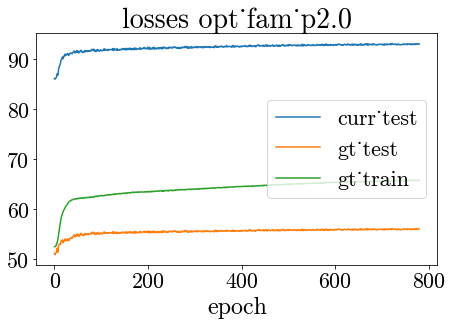

losses opt_fam_p2.0
	curr_test        	 (min:   76.712, max:   93.227, cur:   93.028)
	gt_test          	 (min:   41.593, max:   56.225, cur:   56.073)
	gt_train         	 (min:   41.734, max:   66.044, cur:   65.736)


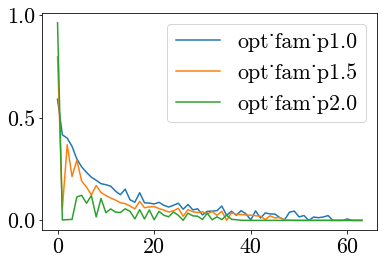

In [ ]:
rand_key = random.PRNGKey(0)

# Signal
M = 2
N = N_train
x_test = np.float32(np.linspace(0,1.,N*M,endpoint=False))
x_train = x_test[::M]


def data_maker(rand_key, N_pts, N_signals, p):
  rand_key, *ensemble = random.split(rand_key, 1 + N_signals)
  data = np.stack([sample_random_powerlaw(ensemble[i], N_pts, p) for i in range(N_signals)])
  data = (data - data.min()) / (data.max() - data.min())  - .5
  return data, rand_key


s_dict = {}
for p in data_powers:
  ret, rand_key = data_maker(rand_key, N*M, N_test_signals, p)
  s_dict['data_p{}'.format(p)] = ret


# Kernels
bvals = np.float32(np.arange(1, N//2+1))
ab_dict = {}
powers = np.linspace(0, 2, 17)
ab_dict.update({'power_{}'.format(p) : (bvals**-p, bvals) for p in powers})
ab_dict['power_infty'] = (np.eye(bvals.shape[0])[0], bvals)


# optimize

ab_opt_dict = {}
t_final = learning_rate * sgd_iters

for p in data_powers:
  k = 'opt_fam_p{}'.format(p)
  ab = ab_dict['power_infty']
  train_signals, rand_key = data_maker(rand_key, N*M, N_train_signals, p)
  rand_key, opt_key = random.split(rand_key)
  a_opt = optimize(opt_key, network_size, train_signals, s_dict['data_p{}'.format(p)][0], t_final, ab, k)

  ab_opt_dict[k] = (a_opt, bvals)

ab_dict.update(ab_opt_dict)

for k in ab_opt_dict:
  plt.plot(np.abs(ab_opt_dict[k][0]), label=k)
plt.legend()
plt.show()


In [ ]:
def train_model_lite(rand_key, network_size, lr, iters, 
                train_input, test_input, optimizer, ab):
    init_fn, apply_fn, kernel_fn = make_network(*network_size)

    run_model = jit(lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab))))
    model_loss = jit(lambda params, ab, x, y: .5 * np.sum((run_model(params, ab, x) - y) ** 2))
    model_psnr = jit(lambda params, ab, x, y: -10 * np.log10(np.mean((run_model(params, ab, x) - y) ** 2)))
    model_grad_loss = jit(lambda params, ab, x, y: jax.grad(model_loss)(params, ab, x, y))

    opt_init, opt_update, get_params = optimizer(lr)
    opt_update = jit(opt_update)

    _, params = init_fn(rand_key, (-1, input_encoder(train_input[0], *ab).shape[-1]))
    opt_state = opt_init(params)

    pred0 = run_model(get_params(opt_state), ab, test_input[0])
    
    for i in (range(iters)):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), ab, *train_input), opt_state)
    
    train_psnr = model_psnr(get_params(opt_state), ab, *train_input)
    test_psnr = model_psnr(get_params(opt_state), ab, test_input[0][1::2], test_input[1][1::2])
    theory = predict_psnr(kernel_fn, test_input[1], pred0, ab, i * lr)

    return get_params(opt_state), train_psnr, test_psnr, theory


print(ab_dict.keys())

outputs = {}
for d_key in tqdm(s_dict):
  s_list = s_dict[d_key]
  outputs[d_key] = {}
  for k in tqdm(ab_dict, leave=False):
    outputs[d_key][k] = []

    rand_key, key = random.split(rand_key)
    train_fn = lambda s, key : train_model_lite(key, network_size, learning_rate, sgd_iters,
                        (x_train, s[::2]), (x_test, s), optimizers.sgd, ab_dict[k])
    
    ensemble_key = random.split(key, s_list.shape[0])
    z = vmap(train_fn, in_axes=(0, 0))(s_list, ensemble_key)
    outputs[d_key][k] = z
    

dict_keys(['power_0.0', 'power_0.125', 'power_0.25', 'power_0.375', 'power_0.5', 'power_0.625', 'power_0.75', 'power_0.875', 'power_1.0', 'power_1.125', 'power_1.25', 'power_1.375', 'power_1.5', 'power_1.625', 'power_1.75', 'power_1.875', 'power_2.0', 'power_infty', 'opt_fam_p1.0', 'opt_fam_p1.5', 'opt_fam_p2.0'])


/home/jupyter-tancik/.conda/envs/jax-tf/lib/python3.7/site-packages/jax/lax/lax.py:5222: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


#Figure

/home/jupyter-tancik/.conda/envs/jax-tf/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/jupyter-tancik/.conda/envs/jax-tf/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


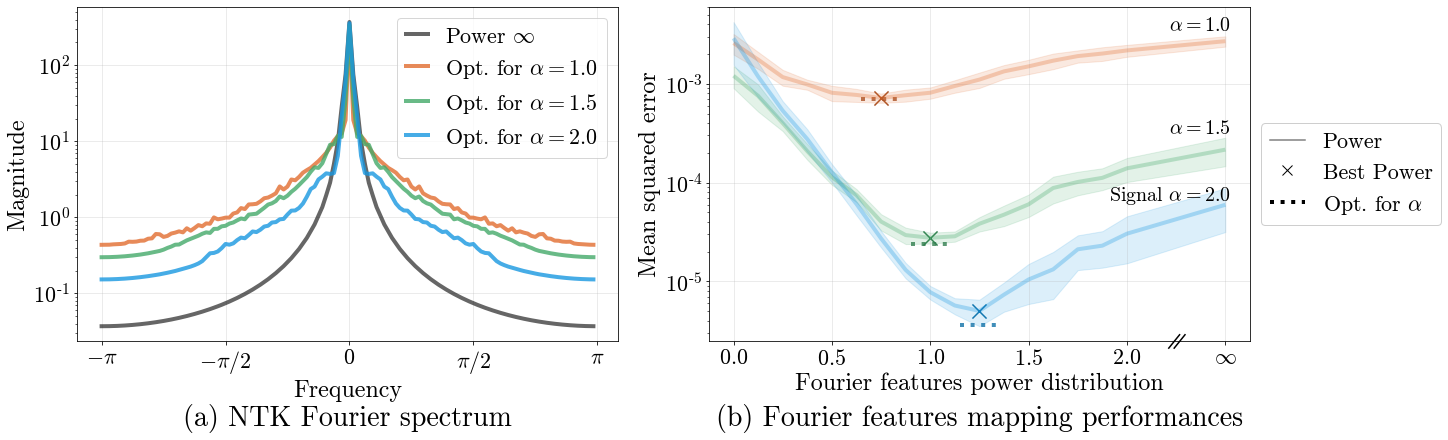

In [ ]:
H_rows = {k : compute_ntk(x_train, *ab_dict[k], make_network(*(network_size))[-1]) for k in ab_dict if 'opt' in k}
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

params = {'legend.fontsize': 22,
         'axes.labelsize': 24,
         'axes.titlesize': 28,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"


N_fams = len(data_powers)


fig3 = plt.figure(constrained_layout=True, figsize=(20,6))
gs = fig3.add_gridspec(1,2)

colors_k = np.array([[0.8872, 0.4281, 0.1875],
    # [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])

linewidth = 4
legend_offset = -.27

ax = fig3.add_subplot(gs[0,0])
fams = ['1.0', '1.5', '2.0']
power_infinity = compute_ntk(x_train, *ab_dict['power_infty'], make_network(*(network_size))[-1])
plt.semilogy(10**fplot(power_infinity), color='k', label=fr'Power $\infty$', linewidth=linewidth, linestyle='-', alpha=.6)
for i, k in enumerate(H_rows):
  plt.semilogy(10**fplot(H_rows[k]), color=colors_k[i], label=fr'Opt. for $\alpha={fams[i]}$', linewidth=linewidth, alpha=.8)
ax.set_title('(a) NTK Fourier spectrum', y=legend_offset)
plt.xticks([0,32,64,96,128], ['$-\pi$','$-\pi/2$','$0$','$\pi/2$','$\pi$'])

ax.legend(loc='upper right', handlelength=1)
plt.xlabel('Frequency')
plt.ylabel(r'Magnitude')
plt.grid(True, which='major', alpha=.3)

for i, d in enumerate(s_dict):
  ax = fig3.add_subplot(gs[0,1])
  
  names = list(outputs[d].keys())

  names = names[:-N_fams] + [names[-N_fams+i]]

  xvals = np.arange(len(names))
  values_raw = np.array([10**(outputs[d][n][2]/-10) for n in names])

  values = np.mean(values_raw, axis=-1)[:-1]
  values_opt = np.mean(values_raw, axis=-1)[-1]
  values_std = np.std(values_raw, axis=-1)[:-1]
  values_std_opt = np.std(values_raw, axis=-1)[-1]

  x_axis = np.linspace(0,2,values.shape[0]-1)
  x_axis = np.append(x_axis, 2.5)
  best_x = np.argmin(values)
  plt.scatter([x_axis[best_x]], [values[best_x]], c=colors_k[i]*.75, s=200, marker='x', )
  ax.hlines(values_opt, xmin=x_axis[best_x]-.1, xmax=x_axis[best_x]+.1, color=colors_k[i]*.75, linestyle=':', linewidth=linewidth, alpha=.8)

  plt.semilogy(x_axis, values, label='Trained', c=colors_k[i], linewidth=linewidth, alpha=.3, solid_capstyle='butt')
  plt.fill_between(x_axis, values-values_std, values+values_std, color=colors_k[i], alpha=.15)
  plt.grid(True, which='major', alpha=.3)

  if i==0:
    ax.set_ylabel('Mean squared error')


plt.text(.85, .93, r'$\alpha=1.0$', transform=ax.transAxes,  fontsize=20)
plt.text(.85, .62, r'$\alpha=1.5$', transform=ax.transAxes,  fontsize=20)
plt.text(.74, .42, r'Signal $\alpha=2.0$', transform=ax.transAxes,  fontsize=20)
plt.xlabel('Fourier features power distribution')
xticks = [0,.5,1,1.5,2,2.5]
ax.set_xticks(xticks)
ax.set_xticklabels(["$0.0$","$0.5$","$1.0$","$1.5$","$2.0$", "$\infty$"])
ax.tick_params(axis='x')

d=.01
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((.86-d, .86+d), (-d*2, d*2), **kwargs)
ax.plot((.87-d, .87+d), (-d*2, d*2), **kwargs)

ax.set_title('(b) Fourier features mapping performances', y=legend_offset)

custom_lines = [Line2D([], [], color='gray', linestyle='-'),
                Line2D([], [], marker='x', color='k', markersize=10, linestyle='None'),
                Line2D([], [], color='k', markersize=10, linestyle=':', linewidth=linewidth)]

ax.legend(custom_lines, ['Power', 'Best Power',r'Opt. for $\alpha$'], loc='center left', bbox_to_anchor=(1,.5),  ncol=1, framealpha=.95, handlelength=1.6)
# ax.legend(custom_lines, [names[0], names[1], names[2], names[3], 'Test', 'Train'], loc='center left', bbox_to_anchor=(1,.5),  ncol=1, framealpha=.95, handlelength=1.6)

plt.savefig('supp_opt.pdf', bbox_inches='tight', pad_inches=0)

plt.show()